# Data Mining - Kaggle Project

## Loading Data

In [36]:
%pylab inline
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.preprocessing import MaxAbsScaler

# for NLP
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import string

import sys
sys.path+=['src']
import data_preprocess

Populating the interactive namespace from numpy and matplotlib


D:\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['test', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Loading Data

In [ ]:
# Reconstruct training data
folder = 'data/train/'
datafile = folder+'train_data.csv'
data_preprocess.merge_csv(folder, datafile)

# Reconstruct Test data
folder = 'data/test/'
datafile = folder+'test_data.csv'
data_preprocess.merge_csv(folder, datafile)

### Training Data

In [37]:
train = pd.read_csv("data/train/train_data.csv", encoding="utf8")


target = pd.read_csv("data/train/train_target.csv")
#target.head()

In [38]:
train.head()

,author,subreddit,created_utc,body
0,Shamus_Aran,mylittlepony,1.388534e+09,I don't think we'd get nearly as much fanficti...
1,Riddance,sex,1.388534e+09,"Thanks. I made it up, that's how I got over my..."
2,Secret_Wizard,DragonsDogma,1.388534e+09,Are you sure you aren't confusing Cyclops (the...
3,Penultimatum,malefashionadvice,1.388534e+09,dont do this to me bro
4,7-SE7EN-7,todayilearned,1.388534e+09,That's what we do when we can't find a mate


In [39]:
target.head()

,author,gender
0,RedThunder90,0
1,Lirkmor,1
2,In0chi,0
3,ProjectGrudge,0
4,TehTurtleHermit,0


How many rows does the training set have

In [40]:
train.shape[0]

296042

In [41]:
target.shape[0]

5000

Checking if there are more comments from the same people

<AxesSubplot:xlabel='author'>

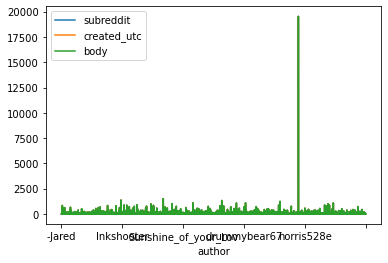

In [42]:
train.groupby('author').count().plot()




Checking how many different users wrote comments

In [43]:
train['author'].unique().shape

(5000,)

One user is ubiquitous, in order to remove bias in the model that user's posts are reduced to the mean value of the comments per user

In [44]:
train.groupby('author').count().describe()


,subreddit,created_utc,body
count,5000.000000,5000.000000,5000.000000
mean,59.208400,59.208400,59.208400
std,298.134567,298.134567,298.134567
min,1.000000,1.000000,1.000000
25%,5.000000,5.000000,5.000000
50%,16.000000,16.000000,16.000000
75%,54.000000,54.000000,54.000000
max,19534.000000,19534.000000,19534.000000


Adding a count column, initialized at 1 for each row

In [45]:
train['count'] = 1
train

,author,subreddit,created_utc,body,count
0,Shamus_Aran,mylittlepony,1.388534e+09,I don't think we'd get nearly as much fanficti...,1
1,Riddance,sex,1.388534e+09,"Thanks. I made it up, that's how I got over my...",1
2,Secret_Wizard,DragonsDogma,1.388534e+09,Are you sure you aren't confusing Cyclops (the...,1
3,Penultimatum,malefashionadvice,1.388534e+09,dont do this to me bro,1
4,7-SE7EN-7,todayilearned,1.388534e+09,That's what we do when we can't find a mate,1
...,...,...,...,...,...
296037,Tashre,FiftyFifty,1.391213e+09,I don't want to play this game anymore :(,1
296038,someguyfromtheuk,AskReddit,1.391213e+09,Twist: I am your son and staged all of this to...,1
296039,spurscanada,HIMYM,1.391213e+09,I think a lot of people don't like her because...,1
296040,SPAZZEH,politics,1.391213e+09,And the Tea Party must be having strokes right...,1


Selecting the outlier by grouping by author and filtering for message count over 1k. Only one user has such a high message counter --> morbiusgreen

In [46]:
train_outlier = train.groupby('author').filter(lambda x: len(x) > 10000)
train_outlier['author'].unique()

array(['morbiusgreen'], dtype=object)

Creating a table without the outlier, in order to understand what is the real mean number of messages per user. In this way, data from the outlier can be still used without completely dropping it, but normalizing it to the other inputs.

In [47]:
#Dropping from train table the rows with author "morbiusgreen". Drop requires index of these rows, so index is provided
train_aux = train.drop(train[train.author == 'morbiusgreen'].index)
train_aux.groupby('author').count().describe()

,subreddit,created_utc,body,count
count,4999.000000,4999.000000,4999.000000,4999.000000
mean,55.312663,55.312663,55.312663,55.312663
std,114.030563,114.030563,114.030563,114.030563
min,1.000000,1.000000,1.000000,1.000000
25%,5.000000,5.000000,5.000000,5.000000
50%,16.000000,16.000000,16.000000,16.000000
75%,54.000000,54.000000,54.000000,54.000000
max,1524.000000,1524.000000,1524.000000,1524.000000


Morbiusgreen is the outlier with a huge number of posts. Let's remove some of the posts and leave about the mean value of posts per user for Morbiusgreen. 

Selecting what percentage of messages from outlier to keep (0.2%).

In [48]:
perc = 55/19534
perc




0.002815603563018327

Keeping the 0.2% of messages from outlier and dropping all the other $1-perc$ messages

In [49]:
train = train.drop(train[train.author == 'morbiusgreen'].sample(frac = 1 - perc).index)

train

,author,subreddit,created_utc,body,count
0,Shamus_Aran,mylittlepony,1.388534e+09,I don't think we'd get nearly as much fanficti...,1
1,Riddance,sex,1.388534e+09,"Thanks. I made it up, that's how I got over my...",1
2,Secret_Wizard,DragonsDogma,1.388534e+09,Are you sure you aren't confusing Cyclops (the...,1
3,Penultimatum,malefashionadvice,1.388534e+09,dont do this to me bro,1
4,7-SE7EN-7,todayilearned,1.388534e+09,That's what we do when we can't find a mate,1
...,...,...,...,...,...
296037,Tashre,FiftyFifty,1.391213e+09,I don't want to play this game anymore :(,1
296038,someguyfromtheuk,AskReddit,1.391213e+09,Twist: I am your son and staged all of this to...,1
296039,spurscanada,HIMYM,1.391213e+09,I think a lot of people don't like her because...,1
296040,SPAZZEH,politics,1.391213e+09,And the Tea Party must be having strokes right...,1


### Test Data

Loading test data

In [50]:
test = pd.read_csv("data/test/test_data.csv", encoding="utf8")
test.head()

,author,subreddit,created_utc,body
0,ejchristian86,TwoXChromosomes,1.388534e+09,I hadn't ever heard of them before joining thi...
1,ZenDragon,gaming,1.388534e+09,"At 7680 by 4320 with 64x AA, right?"
2,savoytruffle,AskReddit,1.388534e+09,bite me
3,hentercenter,stlouisblues,1.388534e+09,Damn that was a good penalty :(
4,rick-o-suave,army,1.388534e+09,I swore into DEP on 6-OCT and I left 5-NOV und...


In [51]:
test.shape[0]

1107946

In [52]:
test[test.author=='ZenDragon']

,author,subreddit,created_utc,body
1,ZenDragon,gaming,1.388534e+09,"At 7680 by 4320 with 64x AA, right?"
27836,ZenDragon,explainlikeimfive,1.388638e+09,"Wrong subreddit for this kind of post, but /r/..."
29348,ZenDragon,Nexus7,1.388642e+09,This is something GravityBox can do. (a module...
55061,ZenDragon,WTF,1.388722e+09,Why is the enclosure even designed like that? ...
90435,ZenDragon,gadgets,1.388845e+09,**Especially** blue ones. They don't instantly...
...,...,...,...,...
1065115,ZenDragon,AskReddit,1.391093e+09,"I ran into my two exes, Alex and Sarah at Swis..."
1080476,ZenDragon,KerbalSpaceProgram,1.391128e+09,Does a spacecraft piloted by a cat always land...
1083575,ZenDragon,programming,1.391135e+09,"Well, yeah... Lua follows old language standar..."
1091883,ZenDragon,AskReddit,1.391169e+09,Jesus man I think ten seconds with a damp clot...


# Feature Extraction

## Reddit subforum

Mapping each subreddit to a numerical value

In [ ]:
subreddits = train.subreddit.unique()
subreddits_map = pd.Series(index=subreddits, data=arange(subreddits.shape[0]))

subreddits_map

In [ ]:
#One hot encoding for the subreddit

from scipy import sparse
def extract_features(group):
    group_subreddits = group['subreddit']
    group_subreddits = group_subreddits[group_subreddits.isin(subreddits_map.index)].values
    idxs = subreddits_map.loc[group_subreddits].values
    v = sparse.dok_matrix((1, subreddits.shape[0]))
    for idx in idxs:
        if not np.isnan(idx):
            v[0, idx] = 1
    return v.tocsr()


extract_features(train[train.author=='RedThunder90'])

Inserting subreddit information in a dictionary, then used to build a matrix X of One-hot-encoded subreddit feature, that will be substituting the subreddit column in the original matrix with multiple, categorical columns in the final design matrix.

In [ ]:
features_dict = {}
test_features_dict = {}

for author, group in train.groupby('author'):
    features_dict[author] = extract_features(group)

for author, group in test.groupby('author'):
    test_features_dict[author] = extract_features(group)
    
test_features_dict


In [56]:
X_subs = sparse.vstack([features_dict[author] for author in target.author])


X_subs_test = sparse.vstack([test_features_dict[author] for author in test.author.unique()])


In [57]:
sparse.save_npz('data/X_subs.npz', X_subs)
sparse.save_npz('data/X_subs_test.npz', X_subs_test)

### Extracting and transforming text

Let's now do feature extraction from the text. First of all, we need to put together all the text written by the specific user, in order to analyze it thoroughly.

For example, user '-Jared' has written several posts; let's gather all the text in one place

In [ ]:
train.loc[train['author']=='-Jared']['body']

In [59]:
def extract_text(group):
    group_text = group['body'].astype(str).values
    full_text = " ".join(group_text)
    return full_text

extract_text(train[train.author=='-Jared'])



'Neil Diamond - Sweet Caroline +1 on the chiropractor. I went religiously from ages 14 - 19 due to extreme lower back pain from running track / cross country. It\'s important to remember it\'s a somewhat slow process, but worth the results. \n\nOh, and don\'t worry, they aren\'t cracking your back - its just an "adjustment"  Looks like the pattern on the envelope that middle school photos came in.  If you had a bad motivator would you want to spell that out every time? And nothing beats a hangover quite like bacon (or better yet, Taylor ham), eggs over easy, toast, and hash browns! No, I think YOU mean Taylor Ham... Really, whatever you call it doesn\'t matter, its damn delicious. '

Let's now gather text for each user.

Lower-case is applied as well. For Bag-of-Words lower_case will be used, whereas for some of other feature, where capital letters or words are evaluated, the one with upper-cases will be used.

In [60]:
#Base
text_dict = {}
test_text_dict = {}
#Lower case
text_dict_lower = {}
test_text_dict_lower = {}

#Training
for author, group in train.groupby('author'):
    full_text = extract_text(group)
    text_dict[author] = full_text
    text_dict_lower[author] = full_text.lower()
    
author_text = [text_dict[author] for author in target.author]
author_text_lower = [text_dict_lower[author] for author in target.author]

#Test
for author, group in test.groupby('author'):
    full_text = extract_text(group)
    test_text_dict[author] = full_text
    test_text_dict_lower[author] = full_text.lower()

test_author_text = [test_text_dict[author] for author in test.author.unique()]
test_author_text_lower = [test_text_dict_lower[author] for author in test.author.unique()]



In [61]:
author_text_lower[4]

"darn, someone already used it.  yep, a co-worker showed me this. as soon as i have the money, i'm canceling my account with sprint. drinking tea with local honey will help, somewhat. bees pollinating  everything, those dirty little bees. as someone who has done support for a ton of video game companies:\n**no.** for kids! i really hate to say, but check out a school system called harmony science academy. i went there from 6th to 12th. one of the requirements of graduation is to get accepted to a 4 year college. they've never had one person not graduate because of it. the teachers all really do care. they are very good with academics, but not so much sports. if you really are looking for a good college prep school, i couldn't recommend a better one. i had an ex give me this. \nex. famine, disease, introduction to native americans?  oh gosh, the return of the king! it is so much fun to play with friends! ironically, i have that same thing on my desk. who would have thought?"

## LEMMATIZATION/STEMMING 

For Bag of Words, a lemmatized text is provided in order to reduce vocabulary and thus number of features, and at the same time limit sparse words such as "Hellllooooo" typical of social media and that are highly unlikely to be present more than once, if ever. This kind of words contain information though, in their meaning. Thus, by applying a lemmatization technique, we are preserving meaning and neglecting the specific modified word.

Since we use Pos-Tagging as a guideline for correct lemmatization, we need to map tags used by Pos-Tagging to the tags used by the Lemmatization tool.

In [27]:
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import string

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''
 

Then we create a translator to remove punctuation. This is the first of the pipeline, in which we clean data from punctuations in order to isolate words

In [28]:
translator = str.maketrans('', '', string.punctuation)

Creating a function that:
1) Removes punctuation

2) Tokenizes text (subdivides text in a list of words, so called tokens)

3) Applies Pos-Tagging, thus giving grammatical context to each one of the tokens

4) Applies Lemmatization, reducing each word to their root. The tag is coherently mapped from Pos-Tag to wordnet through the *get_wordnet_pos* function


In [29]:
def token_pos_lemmatizer(text):
    lemmatizer=WordNetLemmatizer()

    data = text.translate(translator)
    words=word_tokenize(data)
    pos = nltk.pos_tag(words)


    lemmatized_sentence = []
    for tpl in pos:
        tag = get_wordnet_pos(tpl[1])
        if tag != '':
            lemma = lemmatizer.lemmatize(tpl[0], get_wordnet_pos(tpl[1]))
        else: 
            lemma = lemmatizer.lemmatize(tpl[0])
    
        lemmatized_sentence.append(lemma)
    return lemmatized_sentence


#lemmatized_sentence = []
#for tpl in pos:
#    print(tpl)
#    lemma = lemmatizer.lemmatize(tpl[0], tag[1].lower())
#    lemmatized_sentence.append(lemma)
#words = [lemmmatizer.lemmatize(word[0],word[1]) for word in pos]



Applying Lemmatization to all text data. From this point on, we can apply Bag of Words.

In [30]:
lemmatized_data=[]
for author in author_text_lower:
    lemma = token_pos_lemmatizer(author)
    #Creating one single blob of text by joining the lemmatized words, from the list created by the lemmatizer. 
    #This way, the lemmatized data can be fed to a TF-IDF Vectorizer which accepts only blob of strings
    lemmatized_data.append(" ".join(lemma))

lemmatized_data_test=[]
for author in test_author_text_lower:
    lemma = token_pos_lemmatizer(author)
    #Creating one single blob of text by joining the lemmatized words, from the list created by the lemmatizer. 
    #This way, the lemmatized data can be fed to a TF-IDF Vectorizer which accepts only blob of strings
    lemmatized_data_test.append(" ".join(lemma))



Now, with this data we apply Bag-of-Words through a TF-IDF Vectorizer. Features are normalized, thus no further normalization is applied. Furthermore, not all features in the Training Data are selected: a threshold of appearence has been put, so that only features that appear in at least 5% of the texts is accepted. This is done in order to remove outliers (noise) and keeping into account the fact that in social media writing style allows for same words written in different formats, which would appear only once in the whole dataset. This does not provide any information regarding writing style of gender, so it is removed. This should help computation time as well as performance.

Edit: TF-IDF was initially switched-off, as we are looking for writing style rather than topic/content. After performing some tests, TF-IDF seems to give better performance, hence it was turned on.

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(use_idf=True, norm='l2', min_df=0.02)
vectorizer.fit(lemmatized_data)
X_lembow = vectorizer.transform(lemmatized_data)
X_lembow_test = vectorizer.transform(lemmatized_data_test)

X_lembow
X_lembow_test


<15000x3594 sparse matrix of type '<class 'numpy.float64'>'
	with 5062855 stored elements in Compressed Sparse Row format>

Saving the feature to file, so that features will not have to be extracted every time the notebook is closed. At the end of the feature extraction process, all these feature matrices will be stacked together to form the Design Matrix X.

In [32]:
sparse.save_npz('data/X_lembow.npz', X_lembow)
sparse.save_npz('data/X_lembow_test.npz', X_lembow_test)

## Bag of Words 

Evaluating the frequency of the words used in the posts (augmented frequency, in order to eliminate bias towards lengthier documents). The Inverse Document Frequency is switched off (idf=1) since in this specific case it is not relevant to normalize for frequency in documents, the goal here is to evaluate how and what users write in spite of how many users do use the same words and how frequently. 

EDIT: IDF enabled as it provides better performance


In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(use_idf=True, norm='l2', min_df=0.02)
vectorizer.fit(author_text_lower)
X_bow = vectorizer.transform(author_text_lower)
X_bow_test = vectorizer.transform(test_author_text_lower)

In [ ]:
features = vectorizer.get_feature_names_out()
[i for i in features if '' in i]

In [43]:
X_bow

<5000x4414 sparse matrix of type '<class 'numpy.float64'>'
	with 1895202 stored elements in Compressed Sparse Row format>

Saving the feature to file, so that features will not have to be extracted every time the notebook is closed. At the end of the feature extraction process, all these feature matrices will be stacked together to form the Design Matrix X.

In [44]:
sparse.save_npz('data/X_bow.npz', X_bow)
sparse.save_npz('data/X_bow_test.npz', X_bow_test)

## Evaluations on text (extracting new possibly useful features)

The features that might be useful in recognizing gender are:
* Words used (thus a bag of words might be useful, in colloquial english stop-words could be included as well in order to model writing style)
* Average word length --> OK
* Longest word length --> OK
* Misspelling frequency --> NO (computationally heavy, probably not that informative either)
* Profanity frequency --> OK
* Capital word frequency --> OK
* Capital letter frequency --> OK
* Self-reference Frequency --> OK
* Internet acronym frequency --> OK
* Exclamation point frequency --> OK
* Question mark frequency --> OK 
* Quotation mark frequency  --> OK
* Digits frequency --> OK
* Punctuation token frequency --> OK
* Emoticon token frequency --> OK


### Preparation


Creating a splitter/filter that can optionally remove links and punctuation. Optionally it can track single characters as well, as it will be needed for some of the features to be extracted.

Using Fnmatch to filter through wildcards for whatever kind of hyper-links in posts

In [27]:
import fnmatch as fn

filtro = ('*www.*', '*http*', '*.html', '*.gif' )

The splitter/filter function itself. 

Flatten necessary as a workoaround for nested lists that come up when the fn.filter() is applied.

After careful observation of the data, it is noticed that links tend to appear in the following format [TEXT]\(LINK).
In order to retain [TEXT] and remove (LINK) via wildcards, the 2 are separated adding a white-space between parenthesis.

In [28]:
from nltk import flatten
import string

def text_split_filter(sentence, no_links=True, no_punct=True, char=False):
    #Pre-processing in order to remove links
    sentence = sentence.replace('](', '] (')
    
    #Splitting sentence into a list of words
    words = sentence.split()
    
    #Removing Links
    if no_links == True:
        filtered_words = [] #list of words to be filtered out
        for pattern in filtro:
            filtered_words.append(fn.filter(words, pattern)) #if there's a match with any patterns, add it to the list of filtered out words
        filtered_words = flatten(filtered_words)
        words2 = [word for word in words if word not in filtered_words] #Selecting only words that were not filtered out
    else:
        words2 = words #if no filtered out words, just take them all
    
    
    #Removing Punctuation
    words_filtered = []
    if no_punct == True:
        for word in words2: #Consider words that survived filtering process
            #
            words_filtered.append(''.join(filter(lambda x: x not in string.punctuation, word)))
    else: 
         words_filtered = words2
    
    #Subdividing sentence into single chars (no spaces included)
    #Needed for extracting certain features, set to False by default
    if char == True:
        chars = []
        for word in words_filtered:
            letters = [*word]
            chars.append(letters)
        
        return flatten(chars)
    
    else:   
        return words_filtered
    

Now features are extracted both for training and test set

### Average word length

In [ ]:
def avg_word_length(sentence):
    words = text_split_filter(sentence)
    #In case a message is composed by single punctuations chars or links that have been filtered out
    if len(words) == 0:
        return 0
    else:
        average = sum(len(word) for word in words) / (len(words))
        return average  
 
avg_word_feature = []
test_avg_word_feature = []

#Evaluating average word length for each author
for text in author_text:
    wl = avg_word_length(text)
    avg_word_feature.append(wl)
    
for text in test_author_text:
    wl = avg_word_length(text)
    test_avg_word_feature.append(wl)

avg_word_feature


Making the feature into a sparse matrix, to even it out with all the other features. In this case, this matrix will probably not be a sparse one. 

In [241]:
arr = np.array(avg_word_feature)
X_averagelength = sparse.csr_matrix(arr.reshape((5000,1)))

In [242]:
test_arr = np.array(test_avg_word_feature)
X_averagelength_test = sparse.csr_matrix(test_arr.reshape((15000,1)))


Applying feature scaling: these numerical features, by nature, have different scales. Thus, they are normalized such that they weigh the same in ML models and there are no preferential features.

The MaxAbsScaler is chosen, since we want to keep sparsity as a quality of our dataset, so that if a sample has value 0 for the specific feature, it will remain 0 after scaling is applied. 

In [243]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
scaler.fit(X_averagelength)
X_averagelength = scaler.transform(X_averagelength)
X_averagelength_test = scaler.transform(X_averagelength_test)

X_averagelength

<5000x1 sparse matrix of type '<class 'numpy.float64'>'
	with 4999 stored elements in Compressed Sparse Row format>

In [244]:
sparse.save_npz('data/X_averagelength.npz', X_averagelength)
sparse.save_npz('data/X_averagelength_test.npz', X_averagelength_test)

### Max word length

In [ ]:
def long_word(sentence):
    words = text_split_filter(sentence)
    if len(words) == 0:
        return 0
    else:
        print(max(words, key=len))
        return len(max(words, key=len)) #Evaluating 'len' attribute for each word of the array, then selecting max and returning its length



long_word_feature = []
for text in author_text:
    length = long_word(text)
    long_word_feature.append(length)
    
test_long_word_feature = []
for text in test_author_text:
    length = long_word(text)
    test_long_word_feature.append(length)

long_word_feature

In [246]:
arr = np.array(long_word_feature)
X_maxlength = sparse.csr_matrix(arr.reshape((5000,1)))

In [247]:
test_arr = np.array(test_long_word_feature)
X_maxlength_test = sparse.csr_matrix(test_arr.reshape((15000,1)))


In [248]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
scaler.fit(X_maxlength)
X_maxlength = scaler.transform(X_maxlength)
X_maxlength_test = scaler.transform(X_maxlength_test)

In [249]:
sparse.save_npz('data/X_maxlength.npz', X_maxlength)
sparse.save_npz('data/X_maxlength_test.npz', X_maxlength_test)

### Misspelling Frequency (not used)
It takes too long, and the algorithm might not be very accurate. This feature is thus turned off.

In [250]:
#from textblob import Word


In [251]:
#def spell_checker(sentence):
#    words = text_split_filter(sentence)
#    counter = 0
#    for word in words:
#        w = Word(word)
#        check_word = w.spellcheck()
#        if (check_word[0][0] != word):
#            counter += 1
#    
#    return counter
#        
#    

In [252]:
#misspelling_feature = []
#for text in author_text:
#    N = len(text)
#    if N==0:
#        n_misspell = 0
#    else:
#        n_misspell = spell_checker(text)/N
#    misspelling_feature.append(n_misspell)
#
#misspelling_feature

Adding the feature to the feature matrix X.

In [253]:
#arr = np.array(misspelling_feature)
#arr = arr.reshape((5000,1))
#
#X = sparse.hstack([X,arr])
#X

### Profanity Frequency

In [ ]:
df_profanity = pd.read_csv("profanity.csv", encoding="utf8", header=None)
df_profanity = df_profanity[0].str.casefold()
profanity_1 = [badword for badword in df_profanity]

#Since we apply it to text without punctuation (such as '-'), we eliminate punctuation from profanities as well, to match data
profanity = []
for badword in profanity_1:
    profanity.append(''.join(filter(lambda x: x not in string.punctuation, badword)))
profanity

In [33]:
def profanity_filter(text):
    counter = 0
    words = text_split_filter(text)
    for word in words:
        if word in profanity:
            counter += 1
    
    return counter

Using the lower-cased texts, to match the profanities list

In [ ]:
profanity_feature = []
for text in author_text_lower:
    N = len(text_split_filter(text))
    
    if N == 0:
        n_badwords = 0
    else:
        n_badwords = profanity_filter(text)/N
    profanity_feature.append(n_badwords)
    
test_profanity_feature = []
for text in test_author_text_lower:
    N = len(text_split_filter(text))
    
    if N == 0:
        n_badwords = 0
    else:
        n_badwords = profanity_filter(text)/N
    test_profanity_feature.append(n_badwords)
    
profanity_feature

In [35]:
arr = np.array(profanity_feature)
X_profanity = sparse.csr_matrix(arr.reshape((5000,1)))


In [36]:
test_arr = np.array(test_profanity_feature)
X_profanity_test = sparse.csr_matrix(test_arr.reshape((15000,1)))


In [37]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
scaler.fit(X_profanity)
X_profanity = scaler.transform(X_profanity)
X_profanity_test = scaler.transform(X_profanity_test)

In [38]:
sparse.save_npz('data/X_profanity.npz', X_profanity)
sparse.save_npz('data/X_profanity_test.npz', X_profanity_test)

### Capital Words Frequency

Measuring the frequency of FULL CAPITAL words. Only the pronoun "I" is taken out of the counting, for obvious reasons. The idea is to isolate a pattern of highlighting certain words that are not normally written in capital letters.

In [261]:
def capital_words_filter(sentence):
    words = text_split_filter(sentence)
    counter = 0
    for word in words:
        if word != "I":
            capital_bool = word.isupper()
            if capital_bool == True:
                counter += 1
    
    return counter

Obviously, the non-lowered-cased text is used.

In [ ]:
capital_words_feature = []

for text in author_text:
    N = len(text_split_filter(text))
    
    if N == 0:
        capital_words = 0
    else:
        capital_words = capital_words_filter(text)/N
    capital_words_feature.append(capital_words)

test_capital_words_feature = []

for text in test_author_text:
    N = len(text_split_filter(text))
    
    if N == 0:
        capital_words = 0
    else:
        capital_words = capital_words_filter(text)/N
    test_capital_words_feature.append(capital_words)
    
capital_words_feature

In [263]:
arr = np.array(capital_words_feature)
X_capitalwords = sparse.csr_matrix(arr.reshape((5000,1)))

In [264]:
test_arr = np.array(test_capital_words_feature)
X_capitalwords_test = sparse.csr_matrix(test_arr.reshape((15000,1)))

In [265]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
scaler.fit(X_capitalwords)
X_capitalwords = scaler.transform(X_capitalwords)
X_capitalwords_test = scaler.transform(X_capitalwords_test)

In [266]:
sparse.save_npz('data/X_capitalwords.npz', X_capitalwords)
sparse.save_npz('data/X_capitalwords_test.npz', X_capitalwords_test)

### Capital Letters Frequency

Extrapolate tendencies to use capital letters in words in both appropriate (eg. after a full-stop) or inappropriate (eg. "she is Going over There") contexts. THis tendencies may be correlated with gender.

In [267]:
import re

def capital_letter_filter(sentence):
    words = text_split_filter(sentence)
    counter = 0
    for word in words:
        if word != "I":
            capital_counter = len(re.findall('([A-Z])', word))
            counter += capital_counter
    
    return counter

Obviously, the non-lowered-cased text is used.

In [ ]:
capital_letter_feature = []
for text in author_text:
    words = text_split_filter(text)
    N = sum(len(word) for word in words)
    
    if N == 0:
        capital_letter = 0
    else:
        capital_letter = capital_letter_filter(text)/N
    
    capital_letter_feature.append(capital_letter)
    

test_capital_letter_feature = []
for text in test_author_text:
    words = text_split_filter(text)
    N = sum(len(word) for word in words)
    
    if N == 0:
        capital_letter = 0
    else:
        capital_letter = capital_letter_filter(text)/N
    
    test_capital_letter_feature.append(capital_letter)
    
capital_letter_feature

In [269]:
arr = np.array(capital_letter_feature)
X_capitalletters = sparse.csr_matrix(arr.reshape((5000,1)))


In [270]:
test_arr = np.array(test_capital_letter_feature)
X_capitalletters_test = sparse.csr_matrix(test_arr.reshape((15000,1)))


In [271]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
scaler.fit(X_capitalletters)
X_capitalletters = scaler.transform(X_capitalletters)
X_capitalletters_test = scaler.transform(X_capitalletters_test)

In [272]:
sparse.save_npz('data/X_capitalletters.npz', X_capitalletters)
sparse.save_npz('data/X_capitalletters_test.npz', X_capitalletters_test)

### Self-reference Frequency

Evaluating how frequently a user self-references. the key words for this are the ones contained in the "self_dict". 

In [273]:
self_dict = [
'i',
'i\'m',
'im'
'myself',
'me'
]

In [274]:
def self_reference_filter(text):
    words = text_split_filter(text)
    counter = 0
    for word in words:
        if word in self_dict:
            counter += 1
        
    
    return counter

In [ ]:
self_reference_feature = []
for text in author_text_lower:
    N = len(text_split_filter(text))
    
    if N == 0:
        n_self_reference = 0
    else:
        n_self_reference = self_reference_filter(text)/N
    self_reference_feature.append(n_self_reference)

    
test_self_reference_feature = []
for text in test_author_text_lower:
    N = len(text_split_filter(text))
    
    if N == 0:
        n_self_reference = 0
    else:
        n_self_reference = self_reference_filter(text)/N
    test_self_reference_feature.append(n_self_reference)
    
    
self_reference_feature

In [276]:
arr = np.array(self_reference_feature)
X_self = sparse.csr_matrix(arr.reshape((5000,1)))


In [277]:
test_arr = np.array(test_self_reference_feature)
X_self_test = sparse.csr_matrix(test_arr.reshape((15000,1)))


In [278]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
scaler.fit(X_self)
X_self = scaler.transform(X_self)
X_self_test = scaler.transform(X_self_test)

In [279]:
sparse.save_npz('data/X_self.npz', X_self)
sparse.save_npz('data/X_self_test.npz', X_self_test)

### Internet Acronym Frequency

Comparing every single word of each user and checking whether this word is contained in the acronym dictionary. The dictionary was made and edited in capital words: sometimes users write acronyms in non-capital format. For this reason, a non-case sensitive comparison has been made. 

In [ ]:
df_acronyms = pd.read_csv("data/web_acronyms.csv", encoding="utf8", header=None)
df_acronyms = df_acronyms[0].str.casefold()
acronyms_1 = [acronym for acronym in df_acronyms]

acronyms = []
for acr in acronyms_1:
    acronyms.append(''.join(filter(lambda x: x not in string.punctuation, acr)))
acronyms

In [281]:
def acronyms_filter(text):
    words = [word for word in text_split_filter(text)]
    counter = 0
    for word in words:
        if word in acronyms:
            counter += 1
    
    return counter

In [ ]:
acronyms_feature = []
for text in author_text_lower:
    N = len(text_split_filter(text))
    
    if N == 0:
        n_acronyms = 0
    else:
        n_acronyms = acronyms_filter(text)/N
    acronyms_feature.append(n_acronyms)
    

test_acronyms_feature = []
for text in test_author_text_lower:
    N = len(text_split_filter(text))
    
    if N == 0:
        n_acronyms = 0
    else:
        n_acronyms = acronyms_filter(text)/N
    test_acronyms_feature.append(n_acronyms)
    
acronyms_feature

In [283]:
arr = np.array(acronyms_feature)
X_acronyms = sparse.csr_matrix(arr.reshape((5000,1)))


In [284]:
test_arr = np.array(test_acronyms_feature)
X_acronyms_test = sparse.csr_matrix(test_arr.reshape((15000,1)))


In [285]:
scaler = MaxAbsScaler()
scaler.fit(X_acronyms)
X_acronyms = scaler.transform(X_acronyms)
X_acronyms_test = scaler.transform(X_acronyms_test)

In [286]:
sparse.save_npz('data/X_acronyms.npz', X_acronyms)
sparse.save_npz('data/X_acronyms_test.npz', X_acronyms_test)

### EMOTICONS FREQUENCY

In [287]:
#df_emoticons = pd.read_csv("emoticons.csv", encoding="utf8", header=None)
#emoticons = [emo for emo in df_emoticons]
#emoticons

In [39]:
import csv
with open("data/emoticons.txt") as f:
    reader = csv.reader(f, delimiter="\t")
    emoticons = list(reader)


In [40]:
def emoticons_filter(text):
    words = text_split_filter(text, no_punct=False)
    counter = 0
    for word in words:
        for emo in emoticons:
            if word in emo:
                counter += 1
    
    return counter
    


In [ ]:
emoticons_feature = []
for text in author_text:
    N = len(text_split_filter(text, no_punct=False))
    
    if N == 0:
        n_emoticons = 0
    else:
        n_emoticons = emoticons_filter(text)/N
    emoticons_feature.append(n_emoticons)
    
    
test_emoticons_feature = []
for text in test_author_text:
    N = len(text_split_filter(text, no_punct=False))
    
    if N == 0:
        n_emoticons = 0
    else:
        n_emoticons = emoticons_filter(text)/N
    test_emoticons_feature.append(n_emoticons)
    
emoticons_feature

In [42]:
arr = np.array(emoticons_feature)
X_emoticons = sparse.csr_matrix(arr.reshape((5000,1)))


In [43]:
test_arr = np.array(test_emoticons_feature)
X_emoticons_test = sparse.csr_matrix(test_arr.reshape((15000,1)))


In [44]:
scaler = MaxAbsScaler()
scaler.fit(X_emoticons)
X_emoticons = scaler.transform(X_emoticons)
X_emoticons_test = scaler.transform(X_emoticons_test)

In [45]:
sparse.save_npz('data/X_emoticons.npz', X_emoticons)
sparse.save_npz('data/X_emoticons_test.npz', X_emoticons_test)

### Exclamation Mark Frequency

In [46]:
def exclamation_filter(text):
    chars = text_split_filter(text, no_punct=False, char=True)
    counter = 0
    for char in chars:
        if char=='!':
            counter += 1
    
    return counter

In [ ]:
exclamation_feature = []
for text in author_text:
    N = len(text_split_filter(text, no_punct=False, char=True))
    
    if N == 0:
        n_exclamation = 0
    else:
        n_exclamation = exclamation_filter(text)/N
    exclamation_feature.append(n_exclamation)
    
    
test_exclamation_feature = []
for text in test_author_text:
    N = len(text_split_filter(text, no_punct=False, char=True))
    
    if N == 0:
        n_exclamation = 0
    else:
        n_exclamation = exclamation_filter(text)/N
    test_exclamation_feature.append(n_exclamation)
    
exclamation_feature

In [48]:
arr = np.array(exclamation_feature)
X_exclamation = sparse.csr_matrix(arr.reshape((5000,1)))


In [49]:
test_arr = np.array(test_exclamation_feature)
X_exclamation_test = sparse.csr_matrix(test_arr.reshape((15000,1)))


In [50]:
scaler = MaxAbsScaler()
scaler.fit(X_exclamation)
X_exclamation = scaler.transform(X_exclamation)
X_exclamation_test = scaler.transform(X_exclamation_test)

In [51]:
sparse.save_npz('data/X_exclamation.npz', X_exclamation)
sparse.save_npz('data/X_exclamation_test.npz', X_exclamation_test)

### Interrogation Mark Frequency

In [52]:
def interrogation_filter(text):
    chars = text_split_filter(text, no_punct=False, char=True)
    counter = 0
    for char in chars:
        if char=='?':
            counter += 1
    
    return counter

In [ ]:
interrogation_feature = []
for text in author_text:
    N = len(text_split_filter(text, no_punct=False, char=True))
    
    if N == 0:
        n_interrogation = 0
    else:
        n_interrogation = interrogation_filter(text)/N
    interrogation_feature.append(n_interrogation)
    
    
    
test_interrogation_feature = []
for text in test_author_text:
    N = len(text_split_filter(text, no_punct=False, char=True))
    
    if N == 0:
        n_interrogation = 0
    else:
        n_interrogation = interrogation_filter(text)/N
    test_interrogation_feature.append(n_interrogation)
    
    
interrogation_feature

In [54]:
arr = np.array(interrogation_feature)
X_interrogation = sparse.csr_matrix(arr.reshape((5000,1)))


In [55]:
test_arr = np.array(test_interrogation_feature)
X_interrogation_test = sparse.csr_matrix(test_arr.reshape((15000,1)))


In [56]:
scaler = MaxAbsScaler()
scaler.fit(X_interrogation)
X_interrogation = scaler.transform(X_interrogation)
X_interrogation_test = scaler.transform(X_interrogation_test)

In [57]:
sparse.save_npz('data/X_interrogation.npz', X_interrogation)
sparse.save_npz('data/X_interrogation_test.npz', X_interrogation_test)

### Quotation Mark Frequency

In [58]:
def quotation_filter(text):
    chars = text_split_filter(text, no_punct=False, char=True)
    counter = 0
    for char in chars:
        if char=='"':
            counter += 1
    
    return counter

In [ ]:
quotation_feature = []
for text in author_text:
    N = len(text_split_filter(text, no_punct=False, char=True))
    
    if N == 0:
        n_quotation = 0
    else:
        n_quotation = quotation_filter(text)/N
    quotation_feature.append(n_quotation)
    
    
test_quotation_feature = []
for text in test_author_text:
    N = len(text_split_filter(text, no_punct=False, char=True))
    
    if N == 0:
        n_quotation = 0
    else:
        n_quotation = quotation_filter(text)/N
    test_quotation_feature.append(n_quotation)
    
quotation_feature

In [60]:
arr = np.array(quotation_feature)
X_quotation = sparse.csr_matrix(arr.reshape((5000,1)))


In [61]:
test_arr = np.array(test_quotation_feature)
X_quotation_test = sparse.csr_matrix(test_arr.reshape((15000,1)))


In [62]:
scaler = MaxAbsScaler()
scaler.fit(X_quotation)
X_quotation = scaler.transform(X_quotation)
X_quotation_test = scaler.transform(X_quotation_test)

In [63]:
sparse.save_npz('data/X_quotation.npz', X_quotation)
sparse.save_npz('data/X_quotation_test.npz', X_quotation_test)

### Punctutation Frequency

In [64]:
punct_list = string.punctuation
punct_list

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [65]:
def punctuation_filter(text):
    chars = text_split_filter(text, no_punct=False, char=True)
    counter = 0
    for char in chars:
        if char in punct_list:
            counter += 1
    
    return counter

In [ ]:
punctuation_feature = []
for text in author_text:
    N = len(text_split_filter(text, no_punct=False, char=True))
    
    if N == 0:
        n_punctuation = 0
    else:
        n_punctuation = punctuation_filter(text)/N
    punctuation_feature.append(n_punctuation)
    
    
test_punctuation_feature = []
for text in test_author_text:
    N = len(text_split_filter(text, no_punct=False, char=True))
    
    if N == 0:
        n_punctuation = 0
    else:
        n_punctuation = punctuation_filter(text)/N
    test_punctuation_feature.append(n_punctuation)
    
punctuation_feature

In [67]:
arr = np.array(punctuation_feature)
X_punctuation = sparse.csr_matrix(arr.reshape((5000,1)))


In [68]:
test_arr = np.array(test_punctuation_feature)
X_punctuation_test = sparse.csr_matrix(test_arr.reshape((15000,1)))


In [69]:
scaler = MaxAbsScaler()
scaler.fit(X_punctuation)
X_punctuation = scaler.transform(X_punctuation)
X_punctuation_test = scaler.transform(X_punctuation_test)

In [70]:
sparse.save_npz('data/X_punctuation.npz', X_punctuation)
sparse.save_npz('data/X_punctuation_test.npz', X_punctuation_test)

### Digits Frequency

In [71]:
digits_list = [
'0',
'1',
'2',
'3',
'4',
'5',
'6',
'7',
'8',
'9'
]

In [72]:
def digits_filter(text):
    chars = text_split_filter(text, char=True)
    counter = 0
    for char in chars:
        if char in digits_list:
            counter += 1
    
    return counter

In [ ]:
digits_feature = []
for text in author_text:
    N = len(text_split_filter(text, char=True))
    
    if N == 0:
        n_digits = 0
    else:
        n_digits = digits_filter(text)/N
    digits_feature.append(n_digits)
    
    
test_digits_feature = []
for text in test_author_text:
    N = len(text_split_filter(text, char=True))
    
    if N == 0:
        n_digits = 0
    else:
        n_digits = digits_filter(text)/N
    test_digits_feature.append(n_digits)
    
digits_feature

In [74]:
arr = np.array(digits_feature)
X_digits = sparse.csr_matrix(arr.reshape((5000,1)))


In [75]:
test_arr = np.array(test_digits_feature)
X_digits_test = sparse.csr_matrix(test_arr.reshape((15000,1)))


In [76]:
scaler = MaxAbsScaler()
scaler.fit(X_digits)
X_digits = scaler.transform(X_digits)
X_digits_test = scaler.transform(X_digits_test)

In [77]:
sparse.save_npz('data/X_digits.npz', X_digits)
sparse.save_npz('data/X_digits_test.npz', X_digits_test)

# Loading Preprocessed Data

Creating target array

In [ ]:
Y = target.gender
Y

Creating Design Matrix from feature files, using a list of wanted features (in order to perform some tests, it is preferable to have the possibility to choose which features to use).

In [2]:
def generate_matrix(features_all=False, feature_list=['subs', 'lembow', 'averagelength', 'maxlength', 'profanity', 'capitalwords', 'capitalletters', 'self', 'acronyms', 'emoticons', 'exclamation', 'interrogation', 'quotation', 'punctuation', 'digits']):
    "Function that generates the Design Matrix X from single features matrices/arrays"
    l = []
    l_test = []
    
    if features_all == True:
        feature_list_all = ['subs', 'lembow', 'averagelength', 'maxlength', 'profanity', 'capitalwords', 'capitalletters', 'self', 'acronyms', 'emoticons', 'exclamation', 'interrogation', 'quotation', 'punctuation', 'digits']
        for feature in feature_list_all:
            x = sparse.load_npz('data/X_'+str(feature)+'.npz')
            x_test = sparse.load_npz('data/X_'+str(feature)+'_test.npz')
            l.append(x)
            l_test.append(x_test)
        X = sparse.hstack(l)
        X_test = sparse.hstack(l_test)
    else:
        for feature in feature_list:
            x = sparse.load_npz('data/X_'+str(feature)+'.npz')
            x
            x_test = sparse.load_npz('data/X_'+str(feature)+'_test.npz')
            l.append(x)
            l_test.append(x_test)
        X = sparse.hstack(l)
        X_test = sparse.hstack(l_test)
    
    return X, X_test


    
    

Creating the Design Matrix. We can choose which features to include, so that different tests and options of Feature Selection can be performed at will (or if necessary).

In [4]:
feature_list = ['subs', 'lembow', 'averagelength', 'maxlength', 'profanity', 'capitalwords', 'capitalletters', 'self', 'acronyms', 'emoticons', 'exclamation', 'interrogation', 'quotation', 'punctuation', 'digits']#, 'averagelength', 'maxlength', 'profanity', 'capitalwords', 'capitalletters', 'self', 'acronyms', 'emoticons', 'exclamation', 'interrogation', 'quotation', 'punctuation', 'digits']
X, X_test = generate_matrix(features_all=True, feature_list = feature_list)
X


<5000x5228 sparse matrix of type '<class 'numpy.float64'>'
	with 1510259 stored elements in Compressed Sparse Row format>

## Feature Selection

From the way the data has been processed, numerous features have been selected. The dataset dimensionality and feature correlations might hinder some models different from Neural Networks and Trees, that might then be able to perform better if a significative subset of the data is provided to them, rather than all of the variability. 

Hence, different feature techniques have been tried to improve performance and have been entagled in a pipeline in the model selection process (see below).

A filtering feature selection method is applied. Keeping in mind that our input data is numerical and the output is categorical, the ANOVA score is applied. The number of features is given in the model selection process, in which ANOVA is part of the pipeline. Best scoring given for number of features of $\sim$1500

As a notice of work, different feature selection techniques have been tried. In particular Truncated SVD was tested as an alternative method that would keep sparsity untouched, but in the Model Selection/ Hyperparameters Selection, when included in the pipeline, even the best number for singular components to keep did not provide a performance on pair with ANOVA.


In [62]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif #ANOVA

Selecting which features to keep, once the optimal number $k$ is found during the Model Selection process (see below).

In [81]:
selector = SelectKBest(f_classif, k=1520) # k is the number of features to be selected
selector.fit(X, Y)

SelectKBest(k=1520)

Transforming (selecting only relevant features) both Training & Test Set

In [82]:
X = selector.transform(X)
X_test = selector.transform(X_test)

## Machine Learning --> Classification Problem

Loading all the possible classifiers of choice in a dictionary, which contains the parameters as well (these are not directly used, are just personal reminders). The values provided in the code below are those found through model selection procedures in the following section.

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from collections import OrderedDict

models = OrderedDict([
          ('Knn', {"model" : KNeighborsClassifier(n_neighbors=6)
                  ,"best_hyper" : {'n_neighbors' : 6}}),
          ('NaiveBayes', {"model" : MultinomialNB(alpha=1.0240480961923848)
                          ,"best_hyper" : {'alpha' : 1.81}}),
    #Using SAGA optimizer as it is compatible with all types of regularization
          ('LogisticRegression', {"model" : LogisticRegression(C = 2.694026845637584, penalty = 'elasticnet', solver = 'saga', max_iter = 10000, l1_ratio=0.0)
                                 ,"best_hyper" : {'alpha' : 1.38}}),
    
          ('PolySVM', {"model" : SVC(kernel='poly', C=10, degree = 1, gamma = 'auto', probability=False)
                      ,"best_hyper" : {'C' : 10
                                      ,'degree' : 1
                                      ,'gamma' : 'auto'}}),
          ('RBFSVM', {"model" : SVC(kernel='rbf', C=6.222570836730231, gamma=0.051114334834401684, probability=True)
                      ,"best_hyper" : {'C' : 6.222570836730231
                                      ,'gamma' : 0.051114334834401684}}),
    #Selecting Random Splitter since many features are present
          ('ClassificationTree', {'model' : DecisionTreeClassifier(splitter='random', max_depth=2, min_samples_split=12, min_samples_leaf=6, max_features='sqrt')
                                 ,'best_hyper' : {'max_depth' : 2
                                                 ,'min_samples_split' : 4
                                                 ,'min_samples_leaf' : 6
                                                 ,'max_features' : 'auto'}}),
          ('RandomForest', {'model' : RandomForestClassifier(max_depth=32, n_estimators=158, min_samples_split=2, min_samples_leaf=6, max_features='auto',n_jobs = -1)
                           ,'best_hyper' : {'max_depth' : 45
                                           ,'n_estimators' : 300
                                           ,'min_samples_leaf' : 6
                                           ,'min_samples_split' : 4
                                           ,'max_features' : 'auto'}}),
          ('MLP', {"model" : MLPClassifier(hidden_layer_sizes=(4), alpha=24.589178356713425, activation='relu',solver='lbfgs', max_iter=50000)
                  ,"best_hyper" : {'hidden_layer_sizes' : (3)
                                  ,'alpha' : 31.238476953907814}})
        ])


In order to provide a sample of (#layers,#neurons), defining a useful function for MLP hyperparameter optimization, which creates a random sample for the number of hidden layers and neurons. In this way, no manual selection is necessary.

In [67]:
def layers_generator(n_hidden, max_neurons=8, min_neurons=1, samples_per_layer=3):
    """
    Generate samples of layers for MLP
    """
    import itertools
    import random
    hyper_layers = []
    for n in range(1,n_hidden,1):
        hyper_layers.extend(random.sample(list(itertools.product(range(min_neurons,max_neurons,1), repeat=n)), samples_per_layer))
        
    return hyper_layers
    
    #random.sample(list(itertools.product(range(1,20,1), repeat=random.randint(1,5))), 5)

## Model Selection

Defining the Cross-Validation strategy. Since classes are not balanced in the Training set, and considering that removal of data was not considered as an option given the fact that data is already limited in number of samples, a Stratified Cross-Validation is used: in this way, in each fold a proportionate number of samples from each class is used, so that the least possible bias is introduced in the model.

In [69]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

### Hyperparameters Search

In the most promising models, a pipeline is introduced, in order to combine CV with Feature Selection, so as to provide the models the most optimal number of features through which they manage to generalize and correctly predict classes.

Also, to speed up the process and maintain a good hyperparameter research accuracy, a HalvingGrid system is used, sometimes a RandomizedSearch is used to ballpark the hyperparameters values. Then, when a coarse idea has been obtained, these values are fine-tuned through a complete GridSearch to explore all the hyperparameters space and obtain an accurate estimate.

#### KNN

In [ ]:
import scipy.stats as stats
clf = models['Knn']['model']

#After having tried on a larger scale, setting the research to 
#fine-research the best alpha value
hyper = {}
#hyper['C'] = np.logspace(-1.5, 3, 30)
hyper['n_neighbors'] = range(2, 65)

optimizer = GridSearchCV(clf, param_grid= hyper, n_jobs=-1, cv=cv, verbose=3, error_score="raise")
optimizer.fit(X, Y)
print("Best parameters for", str('LR'), "are:")
print(optimizer.best_params_)
print('Score:', str(optimizer.best_score_))
      
clf.C = optimizer.best_params_['n_neighbors']

#### Naive Bayes

Naive Bayes algorithm gives best performance when paired with ANOVA feature selection (1400 features out of $\sim$ 5400). In fact, Naive Bayes is one of the algorithms that works best after dimensionality reduction is applied, since a "selection" of the features is not natuarally incorporated as in models such as Trees and Neural Networks.

In [79]:
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif 

clf = models['NaiveBayes']['model']

#After having tried on a larger scale, setting the research to 
#fine-research the best alpha value
hyper = {}
#hyper['nb__alpha'] = np.logspace(-1.5, 3, 30)
hyper['nb__alpha'] = np.linspace(0.1, 3, 500)
hyper['anova__k'] = np.arange(800, 1600, 10)

pipe = Pipeline([('anova', SelectKBest(f_classif, k = 500)),
                       ('nb', clf)])

optimizer = GridSearchCV(pipe, param_grid= hyper, n_jobs=-1, cv=cv, verbose=3, error_score="raise")
optimizer.fit(X, Y)
print("Best parameters for", str('NaiveBayes'), "are:")
print(optimizer.best_params_)
print('Score:', str(optimizer.best_score_))

Fitting 5 folds for each of 40000 candidates, totalling 200000 fits
Best parameters for NaiveBayes are:
{'anova__k': 1520, 'nb__alpha': 1.0240480961923848}
Score: 0.8702


#### Logistic Regression

In [ ]:
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif 

clf = models['LogisticRegression']['model']

#After having tried on a larger scale, setting the research to 
#fine-research the best alpha value
hyper = {}
#hyper['lr__C'] = np.logspace(-1.5, 3, 30)
hyper['lr__C'] = np.linspace(0.01, 50, 150)
hyper['lr__l1_ratio'] = np.linspace(0,1,20)
hyper['anova__k'] = np.arange(1000, 2000, 20)
#hyper['penalty'] = ['l1', 'l2']

pipe = Pipeline([('anova', SelectKBest(f_classif, k = 500)),
                       ('lr', clf)])

optimizer = HalvingGridSearchCV(pipe, param_grid= hyper, n_jobs=-1, cv=cv, verbose=3, error_score="raise")
optimizer.fit(X, Y)
print("Best parameters for", str('LR'), "are:")
print(optimizer.best_params_)
print('Score:', str(optimizer.best_score_))



#### SVM Poly

In [ ]:
clf = models['PolySVM']['model']

hyper = {}
hyper['C'] = np.linspace(0.001, 10, 500)
hyper['degree'] = range(1,8)
#hyper['gamma'] = ['auto', 'scale']

optimizer = RandomizedSearchCV(clf, param_distributions= hyper,n_iter = 60, cv=cv, verbose=3, error_score="raise")
optimizer.fit(X, Y)

print("Best parameters for", str('LR'), "are:")
print(optimizer.best_params_)
print('Score:', str(optimizer.best_score_))
      
clf.C = optimizer.best_params_['C']
clf.degree = optimizer.best_params_['degree']
#clf.gamma = optimizer.best_params_['gamma']


#### SVM RBF

In [ ]:
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif 

#  if name == "LogisticRegression":
#print('Starting', str(name), 'evaluation. Please wait...')
clf = models['RBFSVM']['model']

hyper = {}

hyper['C'] = np.logspace(-3, 2, 200)
hyper['gamma'] = np.logspace(-3, 2, 200)
#hyper['anova__k'] = np.arange(500, 2000,50)

#pipe = Pipeline([('anova', SelectKBest(f_classif, k=500)),('svm', clf)])

optimizer = HalvingGridSearchCV(clf, param_grid = hyper, cv=cv, verbose=0, error_score="raise")
optimizer.fit(X, Y)

print("Best parameters for", str('LR'), "are:")
print(optimizer.best_params_)
print('Score:', str(optimizer.best_score_))
      
clf.C = optimizer.best_params_['C']

        
 

#### MLP

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif 
#  if name == "LogisticRegression":
#print('Starting', str(name), 'evaluation. Please wait...')
clf = models['MLP']['model']

hyper = {}
#hyper['anova__k'] = np.arange(300, 3300,50)
#hyper['hidden_layer_sizes'] = layers_generator(3, max_neurons=5,samples_per_layer=4)
hyper['alpha'] = np.linspace(1,80, 500)

#pipe = Pipeline([('anova', SelectKBest(f_classif, k=500)),('mlp', clf)])

optimizer = GridSearchCV(clf, param_grid= hyper, cv=cv, verbose=3, error_score="raise")
optimizer.fit(X, Y)

print("Best parameters for", str('LR'), "are:")
print(optimizer.best_params_)
print('Score:', str(optimizer.best_score_))
      
#clf.hidden_layer_sizes = optimizer.best_params_[hidden_layer_sizes']
#clf.alpha = optimizer.best_params_['alpha']
#clf.alpha = optimizer.best_params[]


#### ClassificationTree

In [ ]:
clf = models['ClassificationTree']['model']
hyper = {}
hyper['max_depth'] = range(2, 150, 1)
hyper['min_samples_split'] = np.arange(2,40)
hyper['min_samples_leaf'] = np.arange(1,20)
hyper['max_features'] = ['sqrt', 'auto', 'log2']
      
#Having numerous hyperparameters to check for, a Random search is done
optimizer = HalvingGridSearchCV(clf, param_grid = hyper, cv=cv, n_jobs=-1, verbose=3, error_score="raise")
optimizer.fit(X, Y)

print("Best parameters for", str('LR'), "are:")
print(optimizer.best_params_)
print('Score:', str(optimizer.best_score_))
      
clf.max_depth = optimizer.best_params_['max_depth']
clf.min_samples_split = optimizer.best_params_['min_samples_split']
clf.min_samples_leaf = optimizer.best_params_['min_samples_leaf'] 
clf.max_features = optimizer.best_params_['max_features']

#### RandomForest

In [ ]:
clf = models['RandomForest']['model']
hyper = {}
#hyper['n_estimators'] = range(50, 200, 6)
hyper['max_depth'] = range(50, 150, 5)
hyper['min_samples_split'] = np.arange(2,20)
hyper['min_samples_leaf'] = np.arange(1,40)
hyper['max_features'] = ['sqrt', 'auto', 'log2']
      
#Having numerous hyperparameters to check for, a Random search is done
optimizer = HalvingGridSearchCV(clf, param_grid = hyper, cv=cv, n_jobs=-1, verbose=3, error_score="raise")
optimizer.fit(X, Y)

print("Best parameters for", str('LR'), "are:")
print(optimizer.best_params_)
print('Score:', str(optimizer.best_score_))

#clf.n_estimators = optimizer.best_params_['n_estimators']
clf.max_depth = optimizer.best_params_['max_depth']
clf.min_samples_split = optimizer.best_params_['min_samples_split']
clf.min_samples_leaf = optimizer.best_params_['min_samples_leaf'] 
clf.max_features = optimizer.best_params_['max_features']

## FINAL TRAINING

Once hyperparameters are found, here the actual training is performed. In order to match Kaggle's AUC-ROC metric, a predict_proba method is used to evaluated probabilities for class attribution. The .csv file is formatted such that it matches the output required by the Kaggle's Competition.

In [84]:
result = pd.DataFrame(test.author.unique(), columns=['author'])
clf = models['NaiveBayes']['model']
clf.fit(X, Y)
pred = clf.predict_proba(X_test)
prediction = result
prediction['gender'] = np.array(pred)[:,1].tolist()
prediction.to_csv('{0}\{1}{2}'.format("Results", str('NaiveBayes'), '.csv'), index=False)

**RESULT**: Naive Bayes applied with proper hyperparameter $\alpha$ after ANOVA dimensionality reduction to 1480 features has been applied. Score in Kaggle.

# APPENDIX

## 1.Feature Selection

### Truncated SVD

In [125]:
from sklearn.decomposition import TruncatedSVD



In [ ]:
n = range(1000, 5000, 200)

for x in n:
    svd = TruncatedSVD(x)
    svd.fit(X)

#plt.plot(svd.explained_variance_ratio_)
#plt.xlabel('Number of dimensions')
#plt.ylabel('Explained variance ratio')
#plt.show()

    var_explained = svd.explained_variance_ratio_.sum()
    print(var_explained)
    
    if var_explained>=0.95:
        print ('This is the best number of parameters:', x)
        break;

In [128]:
svd = TruncatedSVD(n_components = 1450)
svd.fit(X)

TruncatedSVD(n_components=1450)

In [131]:
X = svd.transform(X)
X_test = svd.transform(X_test)

In [129]:
var_explained = svd.explained_variance_ratio_.sum()
print(var_explained)

0.87427953724426


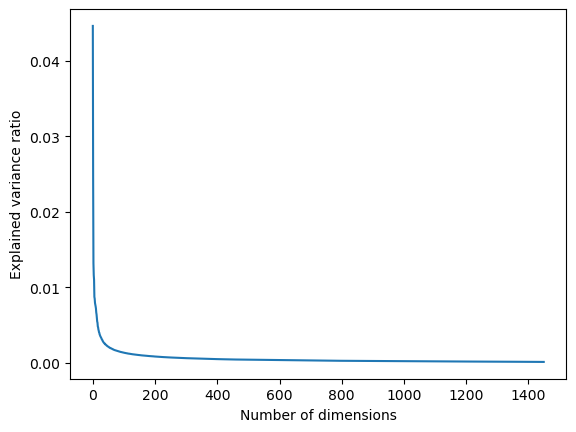

In [130]:
# plot the explained variance ratio as a function of the number of dimensions
plt.plot(svd.explained_variance_ratio_)
plt.xlabel('Number of dimensions')
plt.ylabel('Explained variance ratio')
plt.show()

## Dimensionality Reduction

### Try PCA for NN

Try making matrix dense and do PCA for NN

In [47]:
pip install delayedsparse

  Created wheel for delayedsparse: filename=delayedsparse-0.2.4-py3-none-any.whl size=19763 sha256=b9f82dba24bf83ccb72c640a3a2cd08426711996ce85517e0bb7470fc8b41280
  Stored in directory: c:\users\alber\appdata\local\pip\cache\wheels\74\ca\12\3bc6f3a95c8890be326d46780e2d5b092a4b3ef0e55587cbdd
Successfully built delayedsparse
Note: you may need to restart the kernel to use updated packages.


In [58]:
from sklearn.decomposition import PCA
X_pca = X.todense()
pca = PCA(1056)

pca.fit(X_pca)

U = pca.transform(X_pca)
S = pca.explained_variance_
V = pca.components_

print (U.shape)
print (S.shape)
print (V.shape)

(5000, 1056)
(1056,)
(1056, 5228)


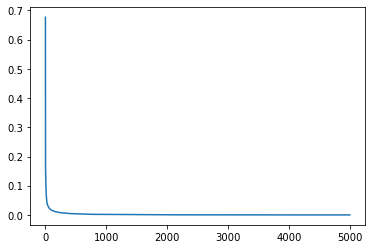

In [56]:
plt.plot(pca.explained_variance_)

1056


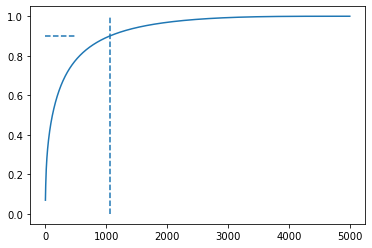

In [57]:
ev_cumsum = np.cumsum(pca.explained_variance_)/(pca.explained_variance_).sum()
ev_at90 = ev_cumsum[ev_cumsum<0.9].shape[0]
print (ev_at90)

plt.plot(ev_cumsum)
plt.vlines(ev_at90, 0, 1, linestyles='dashed')
plt.hlines(0.9, 0, 500, linestyles='dashed');

## Model Selection

### On Categorical Features first, Numerical after

Since the Design Matrix is formed by multiple features, some categorical and some numerical, an attempt has been made to try and separate them to evaluate the hypothesis that models might behave best when dealing with just one kind of feature.

In order to do so, a hyperparameter search is performed on the best performing set of feature ('Subreddits'), then trained with this specific hyperparameter on said feature and then, on the trained model, another hyperparameter search is applied with dimensionality reduction  (since Bag of Word is the most probable set of feature in which either redundancy or noise are found).

### [TESTING] Uso prima i subreddit e poi faccio fine-tuning sulle altre feature ###

In [33]:
feat_subs = ['subs']
feat_rest = ['lembow', 'averagelength', 'maxlength', 'profanity', 'capitalwords', 'capitalletters', 'self', 'acronyms', 'emoticons', 'exclamation', 'interrogation', 'quotation', 'punctuation', 'digits']
X_subs, X_test_subs = generate_matrix(features_all=False, feature_list = feat_subs)
X_rest, X_test_rest = generate_matrix(features_all=False, feature_list = feat_rest)

In [34]:
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif 



clf = models['NaiveBayes']['model']

#After having tried on a larger scale, setting the research to 
#fine-research the best alpha value
hyper = {}
hyper2 = {}
#hyper['C'] = np.logspace(-1.5, 3, 30)
hyper['alpha'] = np.logspace(-3, 2, 500)
#hyper['anova__k'] = np.arange(1000, 1400, 10)

#kbest = SelectKBest(f_classif) 
#pipe = Pipeline([('anova', SelectKBest(chi2, k = 500)), ('nb', clf)])

optimizer1 = GridSearchCV(clf, param_grid= hyper, n_jobs=-1, cv=cv, verbose=3, error_score="raise")
optimizer1.fit(X_subs, Y)

best_alpha1 = optimizer1.best_params_['alpha']
best1 = optimizer1.best_estimator_
print(best1)
#DA PROVARE DOPO
best1.fit(X_subs, Y)

hyper2['nb__alpha'] = np.linspace(best_alpha1-abs(best_alpha1*0.2), best_alpha1 + abs(best_alpha1*0.2), 300) 
hyper2['anova__k'] = np.arange(800, 1700, 10)

pipe = Pipeline([('anova', SelectKBest(f_classif, k = 500)),
                       ('nb', best1)])
optimizer2 = GridSearchCV(pipe, param_grid= hyper2, n_jobs=-1, cv=cv, verbose=3, error_score="raise")
optimizer2.fit(X_rest, Y)

print("Best parameters for", str('LR'), "are:")
print(optimizer2.best_params_)
print('Score:', str(optimizer2.best_score_))
      
#clf.C = optimizer.best_params_['alpha']

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
MultinomialNB(alpha=0.924553109823357)
Fitting 5 folds for each of 27000 candidates, totalling 135000 fits
Best parameters for LR are:
{'anova__k': 1320, 'nb__alpha': 0.7643796948104811}
Score: 0.737
